In [1]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification

num_classes = 3

# Load the XLNet tokenizer and model
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=num_classes)
print('XLNet Model and Tokenizer Loaded Successfully')

# Load ELECTRA model and tokenizer
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
electra_model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=num_classes)
print('ELECTRA Model and Tokenizer Loaded Successfully')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNet Model and Tokenizer Loaded Successfully


Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

ELECTRA Model and Tokenizer Loaded Successfully


In [2]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
filepath  = r'/kaggle/input/fevernli/fr_fever-00000-of-00001-b7ec330d6224f90b.parquet'
table = pq.ParquetDataset(filepath)
df = table.read().to_pandas()
df.head()

,premise_original,hypothesis_original,label,premise,hypothesis
0,Islam . Sizable Muslim communities are also fo...,Islam does not have any followers.,2,Des communautés musulmanes considérables se tr...,L’islam n’a pas d’adeptes.
1,Gemini is a 2002 Indian Tamil-language action ...,Gemini is a movie that came out in 2002.,0,Gemini est un film d'action indien écrit et ré...,Gemini est un film sorti en 2002.
2,Theodore John Kaczynski ( [ kəˈzɪnski ] born M...,Ted Kaczynski is a serial arsonist.,0,Theodore John Kaczynski ( [ kznski ] né le 22 ...,Ted Kaczynski est un pyromane en série.
3,The Shield is an American crime drama televisi...,The Shield is an American military base.,2,The Shield est une série télévisée américaine ...,Le Bouclier est une base militaire américaine.
4,Hugh Jackman . His work in Les Misérables ear...,Hugh Jackman was in the film Les Misérables.,0,Hugh Jackman. Son travail dans Les Misérables ...,Hugh Jackman était dans le film Les Misérables.


In [4]:
df_english = df.drop(columns = ['premise','hypothesis'], axis = 1)
# df_eng = df_english.iloc[:100]

df_french = df.drop(columns= ['premise_original', 'hypothesis_original'], axis = 1)
reorder = ['premise','hypothesis','label']
df_french = df_french.reindex(columns=reorder)
# df_fre = df_french.iloc[:100]

In [5]:
stop_words = set(stopwords.words('english') + stopwords.words('french'))

In [6]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
#     text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Join tokens back into a single string
    processed_text = ' '.join(filtered_tokens)
#     print(processed_text)
    return processed_text

In [7]:
df_pred = pd.read_csv('/kaggle/input/pred-csv/pred_df.csv')
df_pred.head(2)

,premise,hypothesis,label
0,Emily Ratajkowski. La carrière de mannequinage...,Emily Ratajkowski a modélisé pour les publicit...,0
1,National▁Recording▁Registry. Les enregistremen...,Red Headed▁Stranger est une œuvre.,0


In [8]:
# df_english['premise_original'] = df_english['premise_original'].apply(preprocess_text)
# df_english['hypothesis_original'] = df_english['hypothesis_original'].apply(preprocess_text)

df_french['premise'] = df_french['premise'].apply(preprocess_text)
df_french['hypothesis'] = df_french['hypothesis'].apply(preprocess_text)

df_pred['premise'] = df_pred['premise'].apply(preprocess_text)
df_pred['hypothesis'] = df_pred['hypothesis'].apply(preprocess_text)

In [9]:
# Split the data into train, validation, and test sets
french_train, french_test = train_test_split(df_french, test_size=0.2, random_state=42)
print(len(french_train))
print(french_test)



train_df_eng, val_df_eng = train_test_split(french_train, test_size=0.3, random_state=42)
print(len(train_df_eng))
print(len(val_df_eng))
# val_df_eng, test_df_eng = train_test_split(val_test_df_eng, test_size=0.5, random_state=42)

20000
                                                 premise  \
6868   carrière modèle ratajkowski progressé travail ...   
24016  national recording registry . enregistrements ...   
9668   joan crawford ( née lucille fay lesueur ; 23 m...   
13640  metallica groupe heavy metal américain basé sa...   
14018  john stewart , connu sous nom green lantern , ...   
...                                                  ...   
8670   alia bhatt . après avoir fait débuts d'actrice...   
11839  orientations actuelles recherche comprennent d...   
4013   frank premier album studio chanteuse compositr...   
21147  jazz jennings . jennings , adolescente transge...   
695    méchante reine , également connue sous nom méc...   

                                              hypothesis  label  
6868        emily ratajkowski modèle publicités détail .      0  
24016                        red headed stranger œuvre .      0  
9668                  joan crawford n'est qu'allemande .      2  
13640    

In [10]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        premise = str(self.data.iloc[index]['premise'])
        hypothesis = str(self.data.iloc[index]['hypothesis'])
        label = self.data.iloc[index]['label']

        encoding = self.tokenizer.encode_plus(
            premise,
            hypothesis,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': label
        }

In [11]:
# Train, Val, Test -  BERT
# train_dataset_bert = TextDataset(train_df_eng, bert_tokenizer, max_length=300)
# val_dataset_bert = TextDataset(val_df_eng, bert_tokenizer, max_length=300)  
# test_dataset_bert = TextDataset(test_df_eng, bert_tokenizer, max_length=300)  

# # Train, Val, Test -  RoBERTa
# train_dataset_roberta = TextDataset(train_df_eng, roberta_tokenizer, max_length=300)
# val_dataset_roberta = TextDataset(val_df_eng, roberta_tokenizer, max_length=300)  
# test_dataset_roberta = TextDataset(test_df_eng, roberta_tokenizer, max_length=300)  

# Train, Val, Test -  DeBERTa
# train_dataset_deberta = TextDataset(train_df_eng, deberta_tokenizer, max_length=300)
# val_dataset_deberta = TextDataset(val_df_eng, deberta_tokenizer, max_length=300)  
# test_dataset_deberta = TextDataset(french_test[:2000], deberta_tokenizer, max_length=300)  

# Train, Val, Test -  Electra
train_dataset_electra = TextDataset(train_df_eng, electra_tokenizer, max_length=300)
val_dataset_electra = TextDataset(val_df_eng, electra_tokenizer, max_length=300)  
test_dataset_electra = TextDataset(french_test[:2000], electra_tokenizer, max_length=300)  
test_dataset_electra_pred = TextDataset(df_pred, electra_tokenizer, max_length=300)  

# # Train, Val, Test -  Albert
# train_dataset_albert = TextDataset(train_df_eng, albert_tokenizer, max_length=300)
# val_dataset_albert = TextDataset(val_df_eng, albert_tokenizer, max_length=300)  
# test_dataset_albert = TextDataset(test_df_eng, albert_tokenizer, max_length=300)  

# # Train, Val, Test -  DistilBERT
# train_dataset_distilbert = TextDataset(train_df_eng, distilbert_tokenizer, max_length=300)
# val_dataset_distilbert = TextDataset(val_df_eng, distilbert_tokenizer, max_length=300)  
# test_dataset_distilbert = TextDataset(test_df_eng, distilbert_tokenizer, max_length=300)  

# Train, Val, Test -  XLNet
train_dataset_xlnet = TextDataset(train_df_eng, xlnet_tokenizer, max_length=300)
val_dataset_xlnet = TextDataset(val_df_eng, xlnet_tokenizer, max_length=300)  
test_dataset_xlnet = TextDataset(french_test[:2000], xlnet_tokenizer, max_length=300)  
test_dataset_xlnet_pred = TextDataset(df_pred, xlnet_tokenizer, max_length=300)  

In [12]:
# train_loader_bert = DataLoader(train_dataset_bert, batch_size=8, shuffle=True)  
# val_loader_bert = DataLoader(val_dataset_bert, batch_size=8, shuffle=False) 
# test_loader_bert = DataLoader(test_dataset_bert, batch_size=8, shuffle=False)

# train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=8, shuffle=True)  
# val_loader_roberta = DataLoader(val_dataset_roberta, batch_size=8, shuffle=False) 
# test_loader_roberta = DataLoader(test_dataset_roberta, batch_size=8, shuffle=False)

# train_loader_deberta = DataLoader(train_dataset_deberta, batch_size=8, shuffle=True)  
# val_loader_deberta = DataLoader(val_dataset_deberta, batch_size=8, shuffle=False) 
# test_loader_deberta = DataLoader(test_dataset_deberta, batch_size=8, shuffle=False)

train_loader_electra = DataLoader(train_dataset_electra, batch_size=8, shuffle=True)  
val_loader_electra = DataLoader(val_dataset_electra, batch_size=8, shuffle=False) 
test_loader_electra = DataLoader(test_dataset_electra, batch_size=8, shuffle=False)
test_loader_electra_pred = DataLoader(test_dataset_electra_pred, batch_size=8, shuffle=False)

# train_loader_albert = DataLoader(train_dataset_albert, batch_size=8, shuffle=True)  
# val_loader_albert = DataLoader(val_dataset_albert, batch_size=8, shuffle=False) 
# test_loader_albert = DataLoader(test_dataset_albert, batch_size=8, shuffle=False)

# train_loader_distilbert = DataLoader(train_dataset_distilbert, batch_size=8, shuffle=True)  
# val_loader_distilbert = DataLoader(val_dataset_distilbert, batch_size=8, shuffle=False) 
# test_loader_distilbert = DataLoader(test_dataset_distilbert, batch_size=8, shuffle=False)

train_loader_xlnet = DataLoader(train_dataset_xlnet, batch_size=8, shuffle=True)  
val_loader_xlnet = DataLoader(val_dataset_xlnet, batch_size=8, shuffle=False) 
test_loader_xlnet = DataLoader(test_dataset_xlnet, batch_size=8, shuffle=False)
test_loader_xlnet_pred = DataLoader(test_dataset_xlnet_pred, batch_size=8, shuffle=False)

In [13]:
# Set optimizer and loss function

criterion = torch.nn.CrossEntropyLoss()

In [14]:
def train_and_validate(model, train_loader, val_loader, num_epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            # ... (data and target preparation)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += len(labels)

            total_loss += loss.item()

        # Print training accuracy and loss
        train_accuracy = correct_predictions / total_samples
        train_accuracies.append(train_accuracy)
        average_loss = total_loss / len(train_loader)
        train_losses.append(average_loss)
        print(f'Epoch {epoch + 1}: Training Loss = {average_loss:.4f}, Training Accuracy = {train_accuracy:.4f}')

        # Validation
        model.eval()
        total_val_loss = 0
        correct_val_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for batch_val in val_loader:
                input_ids_val = batch_val['input_ids'].to(device)  # Move tensors to the same device as the model
                attention_mask_val = batch_val['attention_mask'].to(device)
                labels_val = batch_val['label'].to(device)

                outputs_val = model(input_ids_val, attention_mask=attention_mask_val, labels=labels_val)
                val_loss = outputs_val.loss
                logits_val = outputs_val.logits

                # Compute validation accuracy
                val_predictions = torch.argmax(logits_val, dim=1)
                correct_val_predictions += (val_predictions == labels_val).sum().item()
                total_val_samples += len(labels_val)

                total_val_loss += val_loss.item()

        # Print validation accuracy and loss
        val_accuracy = correct_val_predictions / total_val_samples
        val_accuracies.append(val_accuracy)
        val_losses.append(total_val_loss / len(val_loader))
        print(f'Validation Loss = {val_losses[-1]:.4f}, Validation Accuracy = {val_accuracies[-1]:.4f}')


    return train_accuracies,train_losses, val_accuracies, val_losses


In [15]:
# print('Bert Model Training')
# tab,tlb,vab,vlb = train_and_validate(bert_model,train_loader_bert, val_loader_bert,3)
# print('RoBerta Model Training')
# tarb,tlrb,varb,vlrb = train_and_validate(roberta_model,train_loader_roberta, val_loader_roberta,3)
# print('DeBerta Model Training')
# tadb,tldb,vadb,vldb = train_and_validate(deberta_model,train_loader_deberta, val_loader_deberta,5)
print('Electra Model Training')
tael,tlel,vael,vlel = train_and_validate(electra_model,train_loader_electra, val_loader_electra,5)
# print('Albert Model Training')
# taal,tlal,vaal,vlal = train_and_validate(albert_model,train_loader_albert, val_loader_albert,3)
# print('DistilBert Model Training')
# tadis,tldis,vadis,vldis = train_and_validate(distilbert_model,train_loader_distilbert, val_loader_distilbert,3)
print('XLNet Model Training')
taxl,tlxl,vaxl,vlxl = train_and_validate(xlnet_model,train_loader_xlnet, val_loader_xlnet,5)



Electra Model Training
Epoch 1: Training Loss = 0.8354, Training Accuracy = 0.6474
Validation Loss = 0.6870, Validation Accuracy = 0.7215
Epoch 2: Training Loss = 0.6568, Training Accuracy = 0.7332
Validation Loss = 0.7145, Validation Accuracy = 0.7350
Epoch 3: Training Loss = 0.5731, Training Accuracy = 0.7770
Validation Loss = 0.6611, Validation Accuracy = 0.7510
Epoch 4: Training Loss = 0.5023, Training Accuracy = 0.8108
Validation Loss = 0.6550, Validation Accuracy = 0.7448
Epoch 5: Training Loss = 0.4455, Training Accuracy = 0.8349
Validation Loss = 0.6714, Validation Accuracy = 0.7558
XLNet Model Training
Epoch 1: Training Loss = 0.7860, Training Accuracy = 0.6710
Validation Loss = 0.6799, Validation Accuracy = 0.7210
Epoch 2: Training Loss = 0.6193, Training Accuracy = 0.7556
Validation Loss = 0.6185, Validation Accuracy = 0.7597
Epoch 3: Training Loss = 0.5072, Training Accuracy = 0.8104
Validation Loss = 0.6314, Validation Accuracy = 0.7620
Epoch 4: Training Loss = 0.4092, Tra

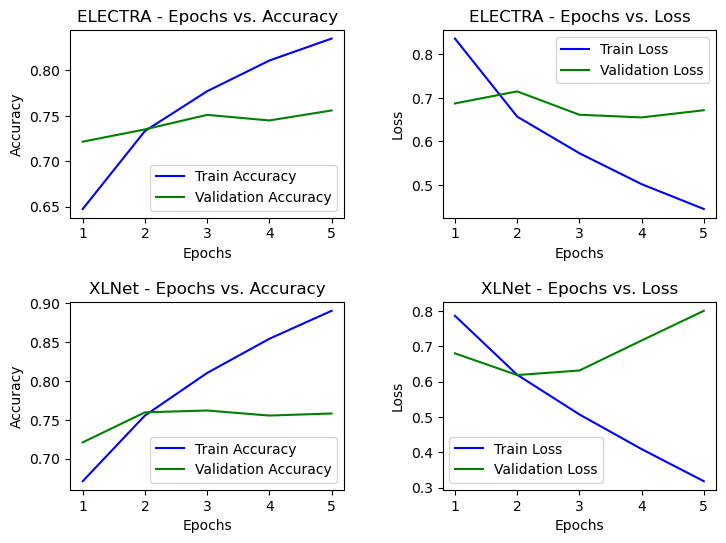

In [16]:
import matplotlib.pyplot as plt

# Assuming you have collected the training and validation data for each model
models = ['ELECTRA','XLNet']
train_accuracies_list = [tael,taxl]
train_losses_list = [tlel,tlxl]
val_accuracies_list = [vael, vaxl]
val_losses_list = [vlel,vlxl]


# Function to convert single float value to a single-item list
def convert_to_list(value):
    return [value] if not isinstance(value, list) else value

# Convert all values to lists and ensure numeric data type for train_losses_list
train_accuracies_list = [convert_to_list(value) for value in train_accuracies_list]
train_losses_list = [[float(loss) for loss in convert_to_list(value)] for value in train_losses_list]
val_accuracies_list = [convert_to_list(value) for value in val_accuracies_list]
val_losses_list = [[float(loss) for loss in convert_to_list(value)] for value in val_losses_list]



# Plot settings
fig, axs = plt.subplots(len(models), 2, figsize=(8, 6))
fig.tight_layout(pad=4.0)

for i, model in enumerate(models):
    # Epochs vs. Accuracy
    axs[i, 0].plot(range(1, len(train_accuracies_list[i]) + 1), train_accuracies_list[i], label='Train Accuracy', color='blue')
    axs[i, 0].plot(range(1, len(val_accuracies_list[i]) + 1), val_accuracies_list[i], label='Validation Accuracy', color='green')
    axs[i, 0].set_title(f'{model} - Epochs vs. Accuracy')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].set_ylabel('Accuracy')
    axs[i, 0].legend()

    # Epochs vs. Loss
    axs[i, 1].plot(range(1, len(train_losses_list[i]) + 1), train_losses_list[i], label='Train Loss', color='blue')
    axs[i, 1].plot(range(1, len(val_losses_list[i]) + 1), val_losses_list[i], label='Validation Loss', color='green')
    axs[i, 1].set_title(f'{model} - Epochs vs. Loss')
    axs[i, 1].set_xlabel('Epochs')
    axs[i, 1].set_ylabel('Loss')
    axs[i, 1].legend()

plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
def test_model(model, test_loader, model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    test_correct_predictions = 0
    total_test_samples = 0
    test_loss = 0
    all_test_predictions = []
    all_test_labels = []

    with torch.no_grad():
        for batch_test in test_loader:
            input_ids_test = batch_test['input_ids'].to(device)
            attention_mask_test = batch_test['attention_mask'].to(device)
            labels_test = batch_test['label'].to(device)

            outputs_test = model(input_ids_test, attention_mask=attention_mask_test, labels=labels_test)
            test_loss += outputs_test.loss.item()

            logits_test = outputs_test.logits
            test_predictions = torch.argmax(logits_test, dim=1)
            test_correct_predictions += (test_predictions == labels_test).sum().item()
            total_test_samples += len(labels_test)
            
            # Collect all predictions and true labels for later evaluation
            all_test_predictions.extend(test_predictions.cpu().numpy())
            all_test_labels.extend(labels_test.cpu().numpy())
    df_predictions = pd.DataFrame({'Predicted Label': all_test_predictions})
    if(model_name == 'ELECTRA'):
        print('1')
        # Save the DataFrame to a CSV file
        output_file = 'test_pred_electra.csv'
        df_predictions.to_csv(output_file, index=False)
    elif(model_name == 'XLNet'):
        print('2')
#         df_predictions = pd.DataFrame({'Predicted Label': all_test_predictions})
        # Save the DataFrame to a CSV file
        output_file = 'test_pred_xlnet.csv'
        df_predictions.to_csv(output_file, index=False)
    elif(model_name == 'ELECTRA_P'):
        print('3')
#         df_predictions = pd.DataFrame({'Predicted Label': all_test_predictions})
        # Save the DataFrame to a CSV file
        output_file = 'test_pred_electra_p.csv'
        df_predictions.to_csv(output_file, index=False)
    else:
        print('4')
#         df_predictions = pd.DataFrame({'Predicted Label': all_test_predictions})
        # Save the DataFrame to a CSV file
        output_file = 'test_pred_xlnet_p.csv'
        df_predictions.to_csv(output_file, index=False)
          
    test_accuracy = test_correct_predictions / total_test_samples
    average_test_loss = test_loss / len(test_loader)
    
    # Calculate additional metrics
    precision = precision_score(all_test_labels, all_test_predictions, average='macro')
    recall = recall_score(all_test_labels, all_test_predictions, average='macro')
    f1 = f1_score(all_test_labels, all_test_predictions, average='macro')
    kappa = cohen_kappa_score(all_test_labels, all_test_predictions)

    print(f'Test Loss = {average_test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}')
    print(f'Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Cohen\'s Kappa = {kappa:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_test_labels, all_test_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    target_names = [f"Class {i}" for i in range(num_classes)]  # Replace num_classes with the number of classes in your dataset
    report = classification_report(all_test_labels, all_test_predictions, target_names=target_names)
    print("Classification Report:")
    print(report)


    return test_accuracy, average_test_loss, precision, recall, f1, kappa,cm

Original French test prediction

In [18]:
models = ['ELECTRA','XLNet']
# test_loader = [test_loader_bert,]
test_accuracies = []
test_losses = []
precision_list = []
recall_list = []
f1_list = []
cohen_kappa_list = []
confusion_matrices = []

for model, model_name, test_loader in zip([electra_model,xlnet_model], models, [test_loader_electra,test_loader_xlnet]):
    print(model_name)
    test_accuracy, test_loss,precision,recall,f1,kappa,cm  = test_model(model, test_loader, model_name)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    cohen_kappa_list.append(kappa)
    confusion_matrices.append(cm)
print('test accuracy',test_accuracies)
print('test losses', test_losses)
print('Precision',precision_list)
print('Recall',recall_list)
print('F1',f1_list)
print('Copen_kappa', cohen_kappa_list)
print('Confusion Matrix', cm)

ELECTRA
1
Test Loss = 0.6396, Test Accuracy = 0.7635
Precision = 0.6884, Recall = 0.6766, F1 Score = 0.6801, Cohen's Kappa = 0.5638
Confusion Matrix:
[[1057   80   83]
 [ 112  146   75]
 [  83   40  324]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.87      0.86      1220
     Class 1       0.55      0.44      0.49       333
     Class 2       0.67      0.72      0.70       447

    accuracy                           0.76      2000
   macro avg       0.69      0.68      0.68      2000
weighted avg       0.76      0.76      0.76      2000

XLNet
2
Test Loss = 0.7771, Test Accuracy = 0.7605
Precision = 0.6916, Recall = 0.6677, F1 Score = 0.6781, Cohen's Kappa = 0.5522
Confusion Matrix:
[[1076   98   46]
 [ 110  164   59]
 [ 111   55  281]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.88      0.85      1220
     Class 1       0.52      0.49      0.50       333
  

In [19]:
import csv
train_accuracies_list = [tael[-1], taxl[-1]]
# print(train_accuracies_list)
val_accuracies_list = [vael[-1], vaxl[-1]]

data_seven_f = [
    ["train_accuracy_seven_f", train_accuracies_list],
    ["val_accuracy_seven_f", val_accuracies_list],
    ["test_accuracy_seven_f", test_accuracies],
    ["precision_seven_f", precision_list],
    ["recall_seven_f", recall_list],
    ["f1_seven_f", f1_list],
    ["kappa_seven_f", cohen_kappa_list]
]

# Export to a CSV file
with open("metrics_seven_fo.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data_seven_f)

Predicted French test prediction

In [20]:
models = ['ELECTRA_P','XLNet_P']
# test_loader = [test_loader_bert,]
test_accuracies = []
test_losses = []
precision_list = []
recall_list = []
f1_list = []
cohen_kappa_list = []
confusion_matrices = []

for model, model_name, test_loader in zip([electra_model,xlnet_model], models, [test_loader_electra_pred,test_loader_xlnet_pred]):
    print(model_name)
    test_accuracy, test_loss,precision,recall,f1,kappa,cm  = test_model(model, test_loader, model_name)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    cohen_kappa_list.append(kappa)
    confusion_matrices.append(cm)
print('test accuracy',test_accuracies)
print('test losses', test_losses)
print('Precision',precision_list)
print('Recall',recall_list)
print('F1',f1_list)
print('Copen_kappa', cohen_kappa_list)
print('Confusion Matrix', cm)

ELECTRA_P
3
Test Loss = 0.7463, Test Accuracy = 0.7240
Precision = 0.6517, Recall = 0.6419, F1 Score = 0.6388, Cohen's Kappa = 0.4984
Confusion Matrix:
[[996  71 153]
 [118 128  87]
 [ 91  32 324]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.82      0.82      1220
     Class 1       0.55      0.38      0.45       333
     Class 2       0.57      0.72      0.64       447

    accuracy                           0.72      2000
   macro avg       0.65      0.64      0.64      2000
weighted avg       0.72      0.72      0.72      2000

XLNet_P
4
Test Loss = 0.8548, Test Accuracy = 0.7380
Precision = 0.6632, Recall = 0.6532, F1 Score = 0.6573, Cohen's Kappa = 0.5179
Confusion Matrix:
[[1040  103   77]
 [ 105  172   56]
 [ 112   71  264]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.85      0.84      1220
     Class 1       0.50      0.52      0.51       333
     Cl

In [21]:
import csv
train_accuracies_list = [tael[-1], taxl[-1]]
# print(train_accuracies_list)
val_accuracies_list = [vael[-1], vaxl[-1]]

data_seven_f = [
    ["train_accuracy_seven_f", train_accuracies_list],
    ["val_accuracy_seven_f", val_accuracies_list],
    ["test_accuracy_seven_f", test_accuracies],
    ["precision_seven_f", precision_list],
    ["recall_seven_f", recall_list],
    ["f1_seven_f", f1_list],
    ["kappa_seven_f", cohen_kappa_list]
]

# Export to a CSV file
with open("metrics_seven_fp.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data_seven_f)

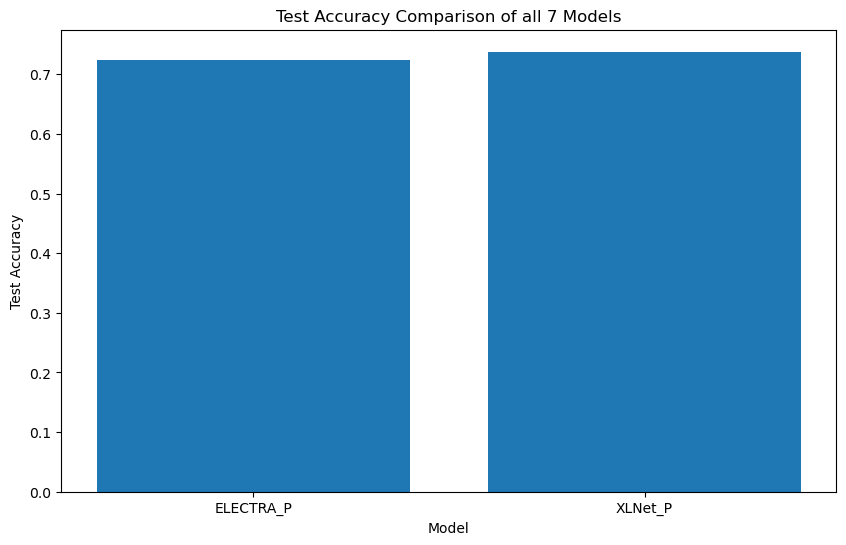

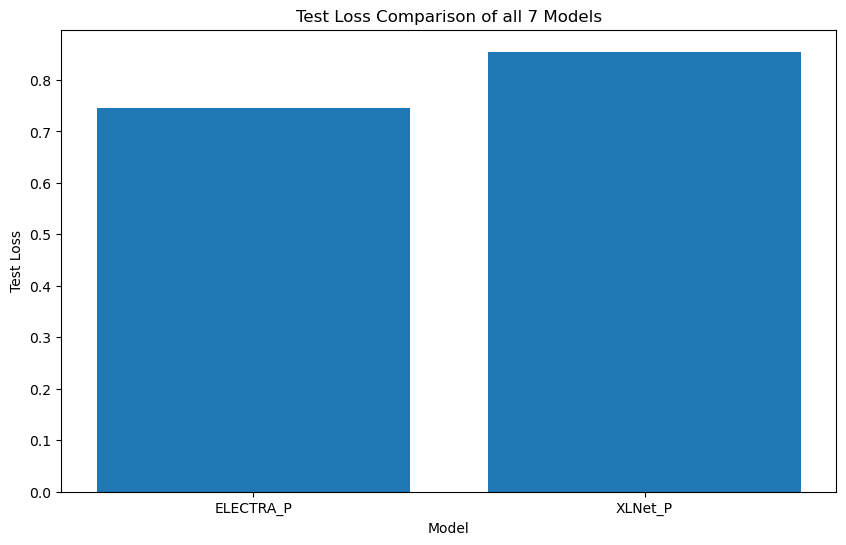

In [22]:
import matplotlib.pyplot as plt

# Plot Test Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(models, test_accuracies)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison of all 7 Models')
plt.show()

# Plot Test Loss Comparison
plt.figure(figsize=(10, 6))
plt.bar(models, test_losses)
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison of all 7 Models')
plt.show()


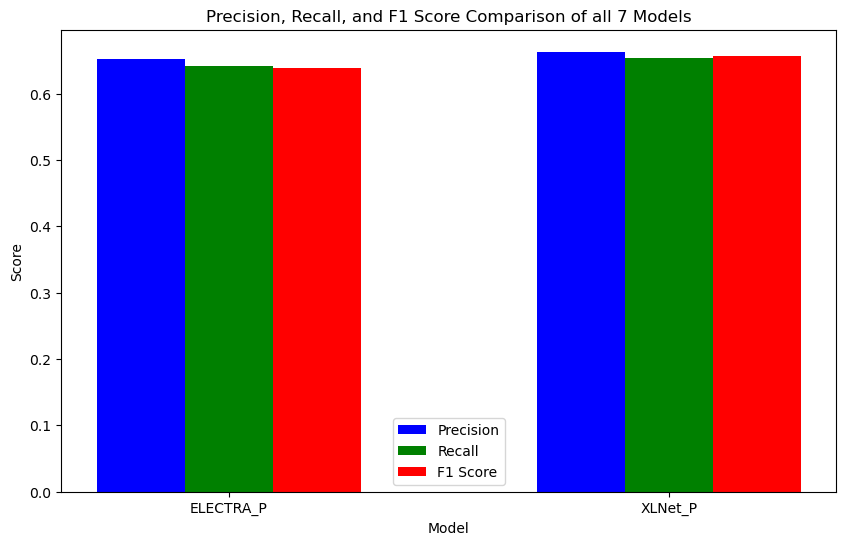

In [23]:
import numpy as np
# Create the grouped bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(models))
plt.bar(index, precision_list, bar_width, label='Precision', color='b')
plt.bar(index + bar_width, recall_list, bar_width, label='Recall', color='g')
plt.bar(index + 2 * bar_width, f1_list, bar_width, label='F1 Score', color='r')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score Comparison of all 7 Models')
plt.xticks(index + bar_width, models)
plt.legend()
plt.show()


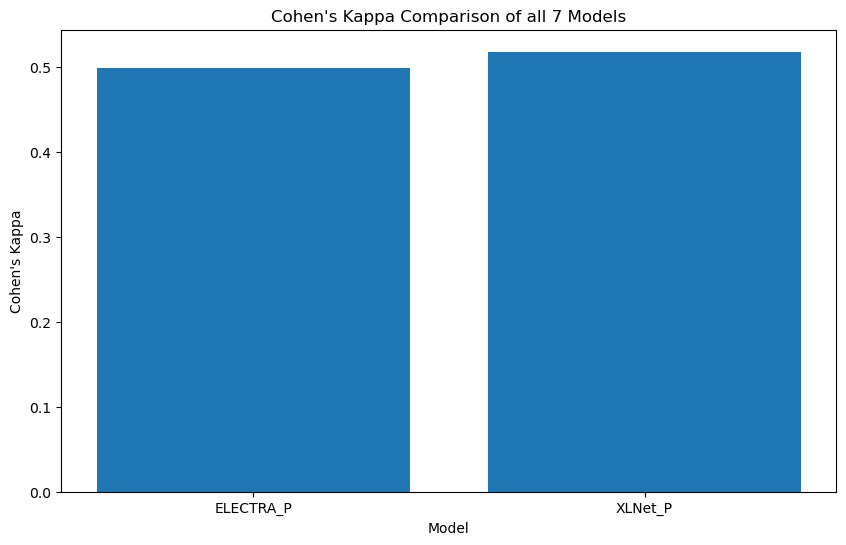

In [24]:
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, cohen_kappa_list)
plt.xlabel('Model')
plt.ylabel("Cohen's Kappa")
plt.title("Cohen's Kappa Comparison of all 7 Models")
plt.show()


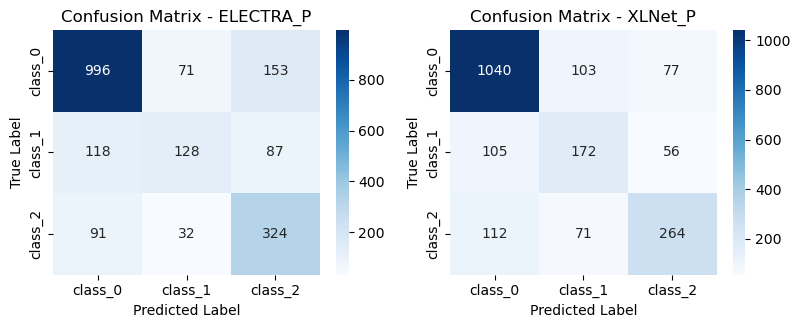

In [25]:
import seaborn as sns
target_names = ['class_0', 'class_1', 'class_2']


# Create the heatmap
plt.figure(figsize=(12, 9))
for i, model in enumerate(models):
    plt.subplot(3, 3, i + 1)
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()
